# Some required imports

In [101]:
import numpy as np
%matplotlib inline
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from scipy.stats import norm
from sympy import Symbol, symbols, Matrix, sin, cos
from sympy import init_printing
init_printing(use_latex=True)
from IPython.display import Latex
from IPython.display import Math

This are our states that we want to estimate;


$$x_k= \left[ \matrix{ p_n \\ h\\ u \\ v \\ \theta \\ b_y \\ w_n } \right] = \left[ \matrix{ \text{Position North} \\ \text{Altitude } \\ \text{Body Velocity along i axis } \\ \text{Body Velocity along j axis} \\ \text{Pitch} \\ \text{Gyro Bias} \\ \text{North Wind}} \right]$$

In [102]:
numstates = 7 #state numbers

In [103]:
dt = 1.0/50.0 # Sample Rate of the Measurements is 50Hz
dtGPS=1.0/10.0 # Sample Rate of GPS is 10Hz

# derive sensors equation;

$$ {y}_{sensors}=\left[\matrix{ {y}_{accel,x}=f_x/mg*sin(\theta)+{n}_{accel,x}\\
{y}_{accel,z} = f_z/m-g*cos(\theta)+{n}_{accel,z}\\
{y}_{gyro,y} = q + b_y + {n}_{gyro,y}\\
{y}_{abs,pres}= \rho*g*{h}_{AGL}+{n}_{abs,pres}\\
{y}_{diff,pres}= \rho*V_a^2/2+{n}_{abs,diff}\\
{y}_{GPS,n}= p_n+{v}_{n}[n]\\
{y}_{GPS,V_g}= V_a+w_n+{n}_{V}}\right] = \left[ \matrix{ \text{x-axis accelorometer} \\ \text{z-axis accelorometer } \\ \text{y-axis gyroscope } \\ \text{statics pressure sensor} \\ \text{differantial pressure sensor} \\ \text{GPS for north position} \\ \text{GPS for ground speed}} \right]$$



# format the variables in latex form

In [104]:
Pn, h, u, v, theta, by, wn, dts, omega, g, g_y, a_x, a_z, n_g ,n_ax, n_az, Q_s, cos, sin  = symbols('p_n h u v theta b_y w_n T omega  g {y}_{gyroy} {y}_{accelx} {y}_{accelz} {n}_{gyroy} {n}_{accelx} {n}_{accelz} Q_s cos sin')

In [105]:
gs = Matrix([[(u*cos(theta))*(omega*sin(theta))],
             [+u*sin(theta)-omega*cos(theta)],
             [-((g_y-by)*omega)-g*sin(theta)+a_x-omega*n_g-n_ax],
             [(g_y-by)*u+g*cos(theta)+a_z+u*n_g-n_az],
             [g_y-by+n_g],
             [0],
             [0]])

state = Matrix([Pn,h,u,omega,theta,by,wn])

# Dynamic Matrix

This formulas calculate how the state is evolving from one to the next time step


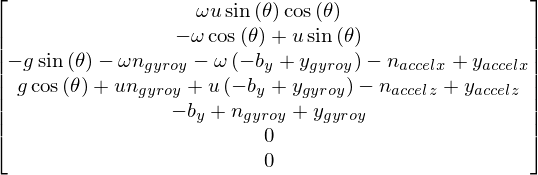

In [106]:
gs

# Jacobian of states

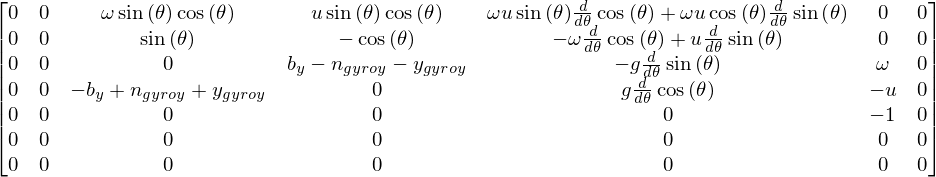

In [107]:
gs.jacobian(state)


# Initial Uncertainty $P$

In [108]:
P = np.diag([5.0**2, 5.0**2, 20.0**2, 10.0**2, (20.0*3.14/180)**2, (20.0*3.14/180)**2,10.0**2])
print(P, P.shape)

(array([[  2.50000000e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   2.50000000e+01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   4.00000000e+02,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.21723457e-01,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.21723457e-01,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.0

# Process Noise Covariance Matrix $Q$



In [109]:
Q = np.diag([0.1**2, 0.1**2, 0.001**2, 0.001**2, 0.001**2, 0.001**2, 0.001**2  ])
print(Q, Q.shape)

(array([[  1.00000000e-02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   1.00000000e-02,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e-06,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e-06,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e-06,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e-06,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.0

# Real Measurements 

In [110]:
datafile = '2014-03-26-000-Data.csv'

date, \
time, \
millis, \
ax, \
ay, \
az, \
rollrate, \
pitchrate, \
yawrate, \
roll, \
pitch, \
yaw, \
speed, \
course, \
latitude, \
longitude, \
altitude, \
pdop, \
hdop, \
vdop, \
epe, \
fix, \
satellites_view, \
satellites_used, \
temp = np.loadtxt(datafile, delimiter=',', unpack=True, 
                  converters={1: mdates.strpdate2num('%H%M%S%f'),
                              0: mdates.strpdate2num('%y%m%d')},
                  skiprows=1)

print('Read \'%s\' successfully.' % datafile)


course =(-course+90.0)

Read '2014-03-26-000-Data.csv' successfully.


# Measurement Function $H$

Matrix $J_H$ is the Jacobian of the Measurement function $h$ with respect to the state. Function $h$ can be used to compute the predicted measurement from the predicted state.

If a GPS measurement is available, the following function maps the state to the measurement.


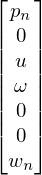

In [111]:
hs = Matrix([[Pn],
             [0],
             [u],
             [omega],
               [0],
               [0],
               [wn]])
hs

# If a GPS measurement is available, the following function maps the state to the measurement.

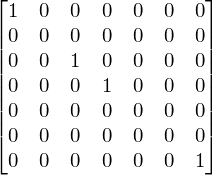

In [112]:
JHs=hs.jacobian(state)
JHs

# Measurement Noise Covariance $R$

In [113]:
varGPS = 0.6 # Standard Deviation of GPS Measurement
varspeed = 0.1 # Variance of the speed measurement
varpress = 1.0  # variance of the pressure measurement
varaccelo = 0.1 #variance of the speed measurement
vargyro = 1.0  #variance of the speed measurement
R = np.matrix([[0.01**2, 0.0, 0.0, 0.0,0.0,0.0,0.0],
               [0.0, 0.01**2, 0.0, 0.0,0.0,0.0,0.0],
               [0.0, 0.0, 0.001**2,0.0,0.0,0.0,0.0],
               [0.0, 0.0, 0.0, 0.001**2,0.0,0.0,0.0],
               [0.0, 0.0, 0.0, 0.0,0.001**2,0.0,0.0],
               [0.0, 0.0, 0.0, 0.0,0.0,0.01**2,0.0],
                [0.0, 0.0, 0.0, 0.0,0.0,0.0,0.001**2]
              ],)

print(R, R.shape)

(matrix([[  1.00000000e-04,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,   1.00000000e-04,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e-06,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           1.00000000e-06,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   1.00000000e-06,   0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   1.00000000e-04,
           0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0

# Identity Matrix

In [114]:
I = np.eye(numstates)
print(I, I.shape)

(array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.]]), (7, 7))


# Initial state

In [115]:
RadiusEarth = 6378388.0 # m
arc= 2.0*np.pi*(RadiusEarth+altitude)/360.0 # m/°

dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # in m
dz = arc * np.hstack((0.0, np.diff(latitude))) # in m

mx = np.cumsum(dx)
mz = np.cumsum(dz)

ds = np.sqrt(dx**2+dz**2)

GPS=np.hstack((True, (np.diff(ds)>0.0).astype('bool'))) # GPS Trigger for Kalman Filter

(matrix([[  4.76460000e-03],
        [ -2.06454600e-01],
        [  6.73222222e-01],
        [  1.51350000e+00],
        [  3.31950000e+00],
        [ -1.87130000e+01],
        [ -4.27268220e-01]]), (7, 1))


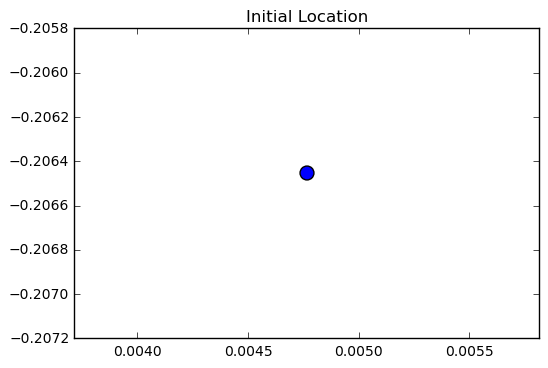

In [116]:
x = np.matrix([[(mx[0]+dt*ax[0])*0.9,(mz[0]+dt*az[0])*1.1, speed[0]/3.6+0.001, speed[0]/1.6+0.001, 
                pitch[0],yawrate[0],speed[0]*np.sin(pitch[0])+0.001]]).T
print(x, x.shape)

U=float(np.cos(x[2])*x[3])
V=float(np.sin(x[2])*x[3])

plt.quiver(x[0], x[1], U, V)
plt.scatter(float(x[0]), float(x[1]), s=100)
plt.title('Initial Location')
plt.axis('equal')

# Put all values together

In [117]:
measurements = np.vstack((mx*0.9, mz*1.1, speed/1.2+0.001, speed/1.4+0.001, pitch, yawrate, speed*np.sin(pitch)))
# Lenth of the measurement
m = measurements.shape[1]
print(measurements.shape)

(7, 10800)


In [118]:
# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
x6 = []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Pddx=[]
Pddy=[]
Pdv =[]
Pby =[]
Pwn =[]
Kx = []
Ky = []
Kdx= []
Kdy= []
Kddx=[]
Kdv= []
Kby= []
Kwn= []
dstate=[]

# Iterate

In [119]:
for filterstep in range(m):

    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    # see "Dynamic Matrix"
    if np.abs(pitchrate[filterstep])<0.0001: # Driving straight
        x[0] =  x[2]*np.cos(x[4])+ x[3]*np.sin(x[4])*ax[filterstep]
        x[1] = x[2]*np.sin(x[4])- x[3]*np.cos(x[4])
        x[2] =  speed[filterstep]/1.3 +ax[filterstep] 
        x[3] =  speed[filterstep]/1.7 +az[filterstep] 
        x[4] =  pitch[filterstep]
        x[5] = x[5] 
        x[6] = x[6]+dt*yawrate[filterstep]
        dstate.append(0)
    else: # otherwise
        x[0] =  x[2]*np.cos(x[4])+ x[3]*np.sin(x[4])+ax[filterstep-1] 
        x[1] = x[2]*np.sin(x[4])- x[3]*np.cos(x[4])
        x[2] =  speed[filterstep-1]/1.3 +ax[filterstep-1] 
        x[3] =  speed[filterstep-1]/1.7 +az[filterstep-1] 
        x[4] =  pitch[filterstep-1]+pitchrate[filterstep-1]
        x[5] = x[5] 
        x[6] = x[6] + dt*yawrate[filterstep-1]
        dstate.append(1)
    
    # Calculate the Jacobian of the Dynamic Matrix A
    # see "Calculate the Jacobian of the Dynamic Matrix with respect to the state vector"
    a13 = float(np.cos(x[4]))
    a14 = float(np.sin(x[4]))
    a15 = float(-np.sin(x[4])*x[2]+np.cos(x[4])*x[3])
    a23 = float(np.sin(x[4]))
    a24 = float(np.cos(x[4]))
    a25 = float(np.cos(x[4])*x[2]+np.sin(x[4])*x[3])
    a34 = float(-x[5])  
    a35 = float(-9.81*np.sin(x[4]))
    a36 = float(x[3])  
    a43 = float(-x[5]) 
    a45 = float(9.81*dt*np.cos(x[4]))
    a46 = float(-x[2])            
                
    JA = np.matrix([[0.0, 0.0, a13, a14, a15, 0.0, 0.0],
                    [0.0, 0.0, a23, -a24, a25, 0.0, 0.0],
                    [0.0, 0.0, 0.0, a34, a35, a36,  0.0],
                    [0.0, 0.0, a43, 0.0, a45, -a46,  0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
    
    
    # Project the error covariance ahead
    P = JA*P*JA.T + Q
    
    # Measurement Update (Correction)
    # ===============================
    # Measurement Function
    hx = np.matrix([[float(x[0])],
                    [float(x[1])],
                    [float(x[2])],
                    [float(x[3])],
                    [float(x[4])],
                    [float(x[5])],
                    [float(x[6])]])

    if GPS[filterstep]: # with 10Hz, every 5th step
        JH = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
    else: # every other step
        JH = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])       
    
    S = JH*P*JH.T + R
    K = (P*JH.T) * np.linalg.inv(S)

    # Update the estimate via
    Z = measurements[:,filterstep].reshape(JH.shape[0],1)
    y = Z - (hx)                        
    x = x + (K*y)

    # Update the error covariance
    P = (I - (K*JH))*P


    # Save states for Plotting
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    x5.append(float(x[5]))
    x6.append(float(x[6]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Pddx.append(float(P[4,4]))
    Pdv.append(float(P[5,5]))
    Pby.append(float(P[6,6]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    Kddx.append(float(K[4,0]))
    Kdv.append(float(K[5,0]))
    Kwn.append(float(K[6,0]))

    

uncertinities

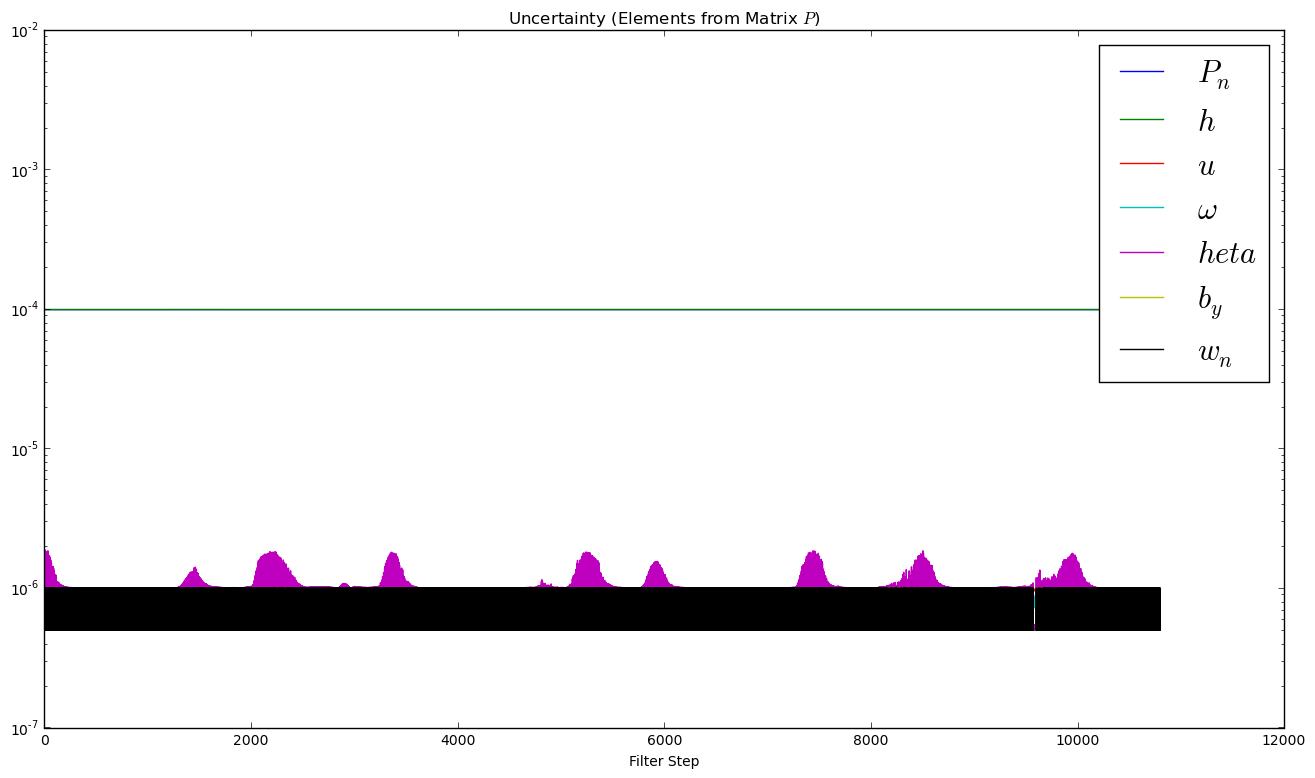

In [120]:
fig = plt.figure(figsize=(16,9))
plt.semilogy(range(m),Px, label='$P_n$')
plt.step(range(m),Py, label='$h$')
plt.step(range(m),Pdx, label='$u$')
plt.step(range(m),Pdy, label='$\omega$')
plt.step(range(m),Pddx, label='$\theta$')
plt.step(range(m),Pdv, label='$b_y$')
plt.step(range(m),Pby, label='$w_n$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Uncertainty (Elements from Matrix $P$)')
plt.legend(loc='best',prop={'size':22})

kalman gains

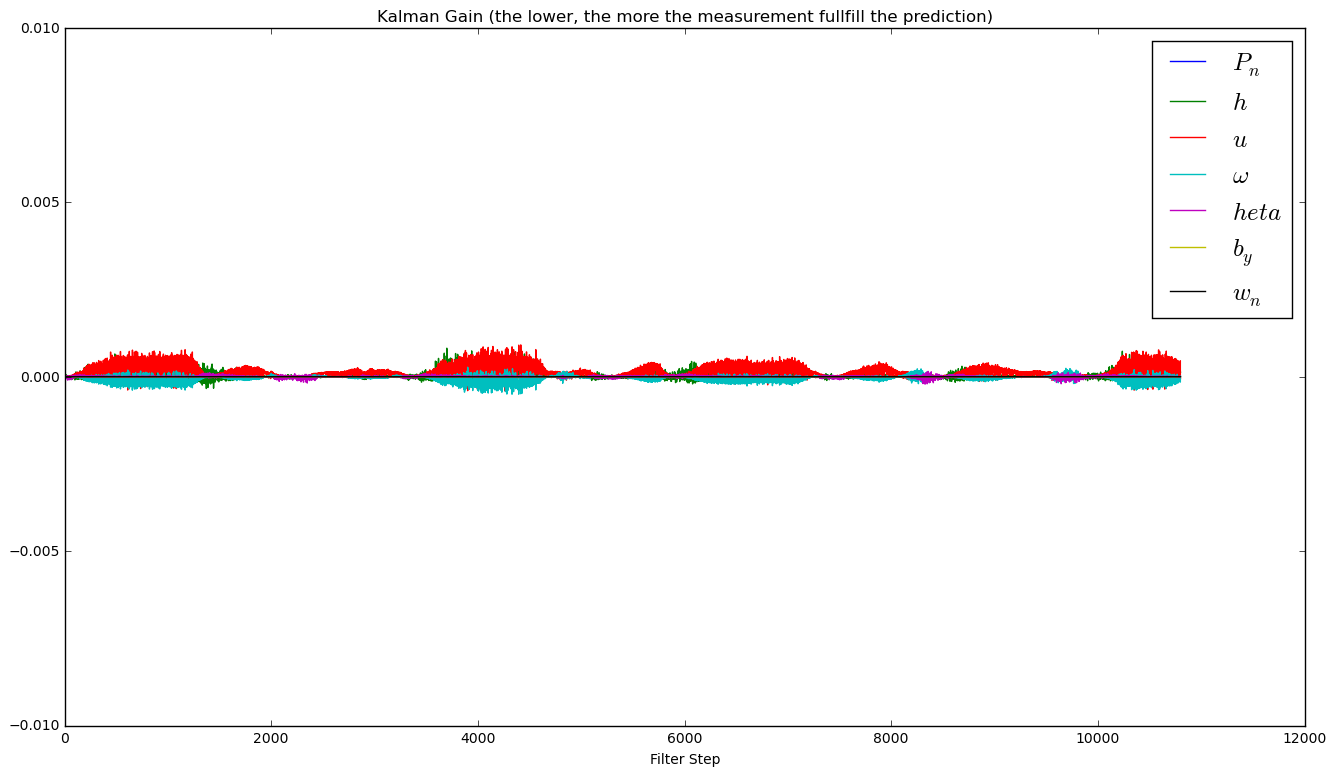

In [121]:
fig = plt.figure(figsize=(16,9))
plt.step(range(len(measurements[0])),Kx, label='$P_n$')
plt.step(range(len(measurements[0])),Ky, label='$h$')
plt.step(range(len(measurements[0])),Kdx, label='$u$')
plt.step(range(len(measurements[0])),Kdy, label='$\omega$')
plt.step(range(len(measurements[0])),Kddx, label='$\theta$')
plt.step(range(len(measurements[0])),Kdv, label='$b_y$')
plt.step(range(len(measurements[0])),Kwn, label='$w_n$')



plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
plt.legend(prop={'size':18})
plt.ylim([-0.01,0.01]);

state vector

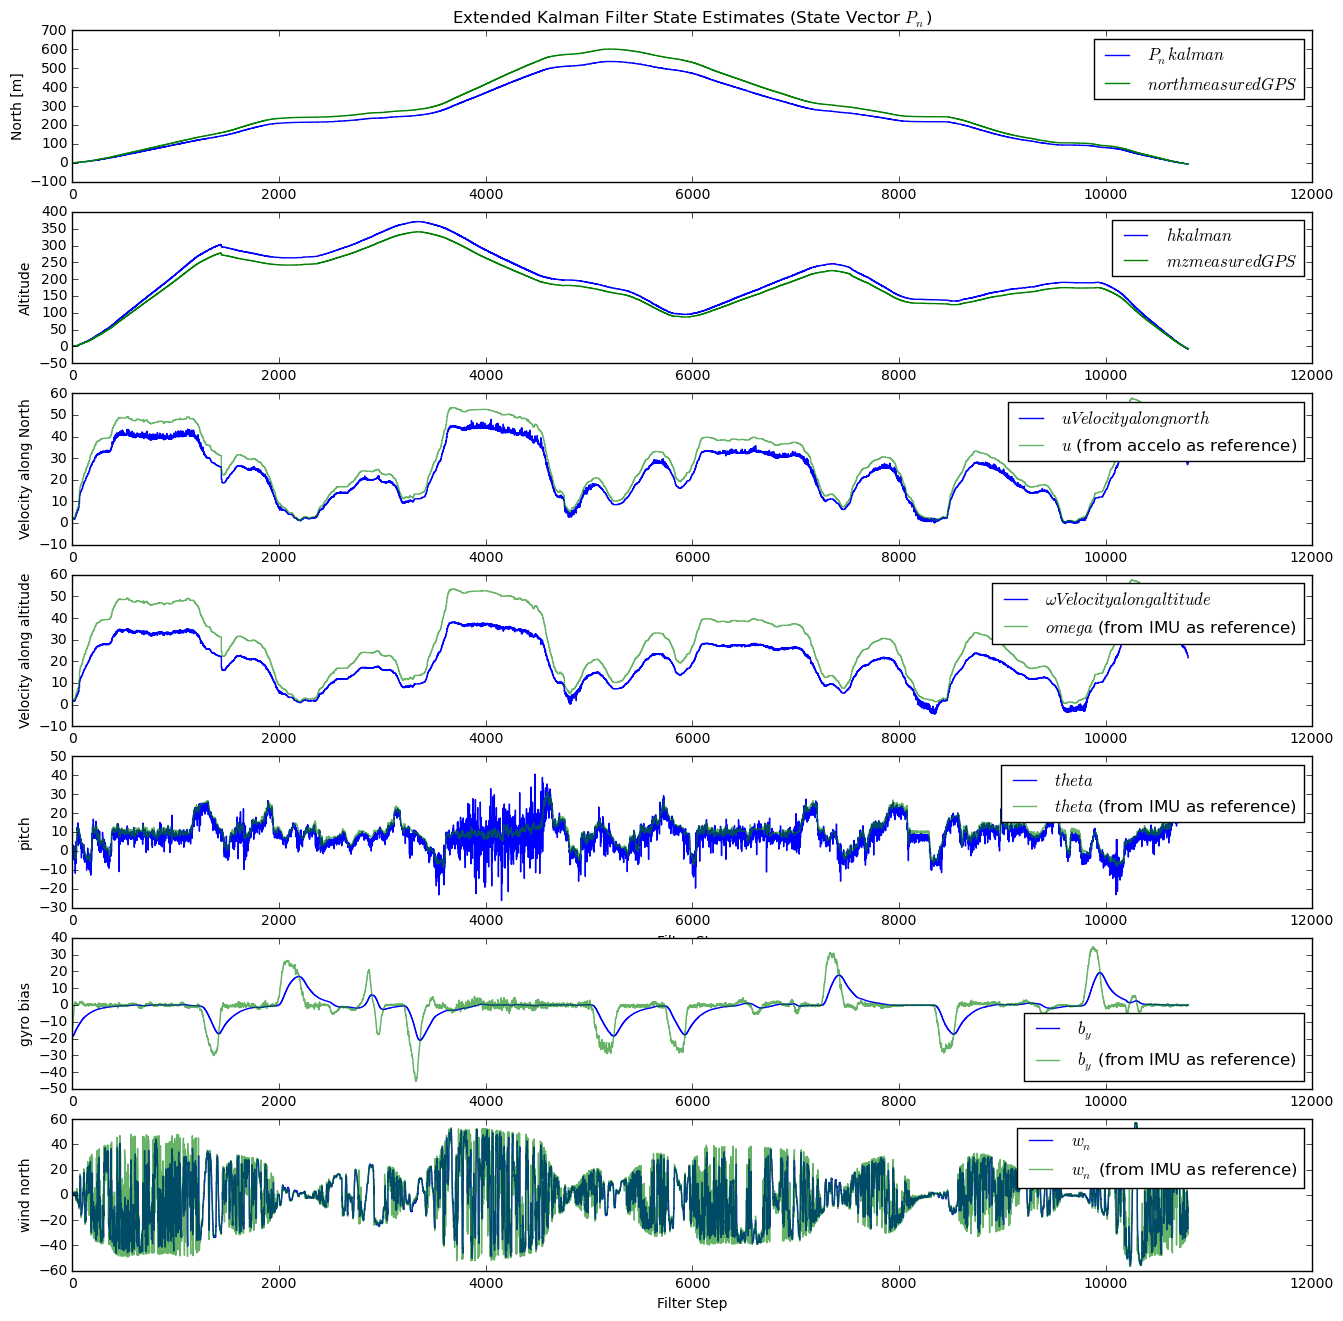

In [122]:
fig = plt.figure(figsize=(16,16))

plt.subplot(711)
plt.step(range(len(measurements[0])),x0, label='$P_n kalman$')
plt.step(range(len(measurements[0])),mx, label='$north measured GPS$')
plt.title('Extended Kalman Filter State Estimates (State Vector $P_n$)')
plt.legend(loc='best')
plt.ylabel('North [m]')


plt.subplot(712)
plt.step(range(len(measurements[0])),x1, label='$h kalman$')
plt.step(range(len(measurements[0])),mz, label='$mz measured GPS $')
plt.ylabel('Altitude')
plt.legend(loc='best')
           
plt.subplot(713)
plt.step(range(len(measurements[0])),x2, label='$u Velocity along north$')
plt.step(range(len(measurements[0])),speed, label='$u$ (from accelo as reference)', alpha=0.6)
plt.ylabel('Velocity along North')
#plt.ylim([0, 30])
plt.legend(loc='best')

plt.subplot(714)
plt.step(range(len(measurements[0])),x3, label='$\omega Velocity along altitude$')
plt.step(range(len(measurements[0])),speed, label='$omega$ (from IMU as reference)', alpha=0.6)
plt.ylabel('Velocity along altitude')
#plt.ylim([0, 30])
plt.legend(loc='best')

plt.subplot(715)
plt.step(range(len(measurements[0])),x4, label='$theta$')
plt.step(range(len(measurements[0])),pitch, label='$theta$ (from IMU as reference)', alpha=0.6)
plt.ylabel('pitch')
#plt.ylim([-50, 50])
plt.legend(loc='best')
plt.xlabel('Filter Step')

plt.subplot(716)
plt.step(range(len(measurements[0])),x5, label='$b_y$')
plt.step(range(len(measurements[0])),yawrate, label='$b_y$ (from IMU as reference)', alpha=0.6)
plt.ylabel('gyro bias')
#plt.ylim([-0.6, 0.6])
plt.legend(loc='best')

plt.subplot(717)
plt.step(range(len(measurements[0])),x6, label='$w_n$')
plt.step(range(len(measurements[0])),speed*np.sin(pitch), label='$w_n$ (from IMU as reference)', alpha=0.6)
plt.ylabel('wind north')
#plt.ylim([-0.6, 0.6])
plt.legend(loc='best')
plt.xlabel('Filter Step')

plt.savefig('Kalman-Filter-State-Estimates.png', dpi=72, transparent=True, bbox_inches='tight')